# Introduction
This colab worksheet provides a starting point for the computer vision assignment.

# Data Loading

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz



--2024-05-15 09:59:17--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-15 09:59:18--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-15 09:59:18--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')



# Load the data

In [ ]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(2811, 256, 256, 3) (2811, 44, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

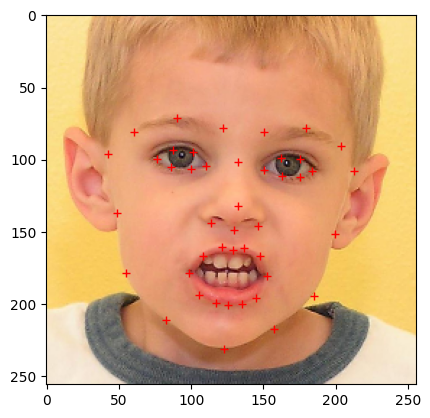

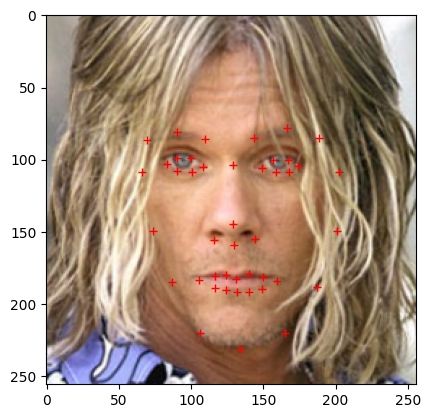

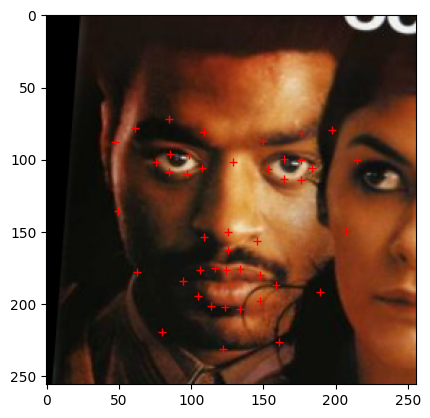

In [ ]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 44 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Normalizing our images
images = images / 255.0
test_images = test_images / 255.0

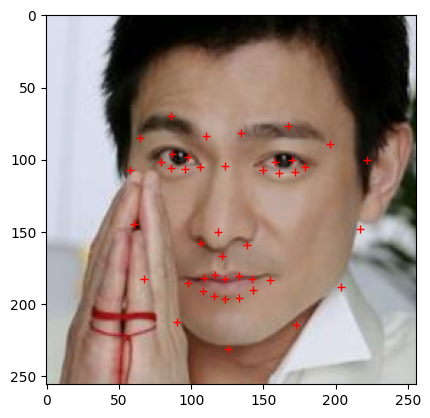

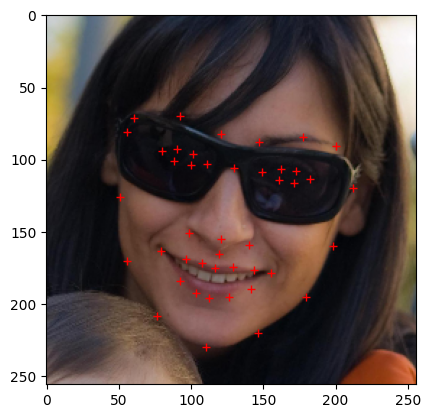

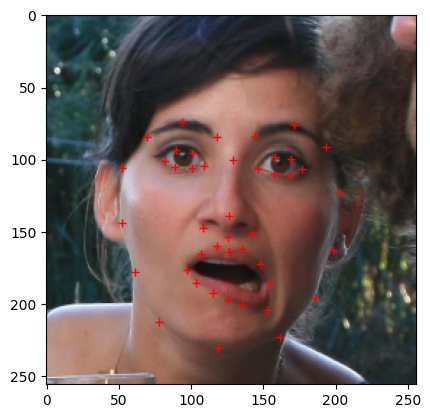

In [ ]:
# Plot normalized images
for i in range(3):
    idx = np.random.randint(0, images.shape[0])
    visualise_pts(images[idx], pts[idx])

In [ ]:
# Data augmentation process
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Generating augmented images for visualization
augmented_images, augmented_pts = [], []
for i in range(3):
    idx = np.random.randint(0, images.shape[0])
    img, pt = images[idx], pts[idx]
    img = img.reshape((1,) + img.shape)
    augmented_iter = datagen.flow(img, batch_size=1)
    augmented_image = next(augmented_iter)[0]
    augmented_images.append(augmented_image)
    augmented_pts.append(pt)

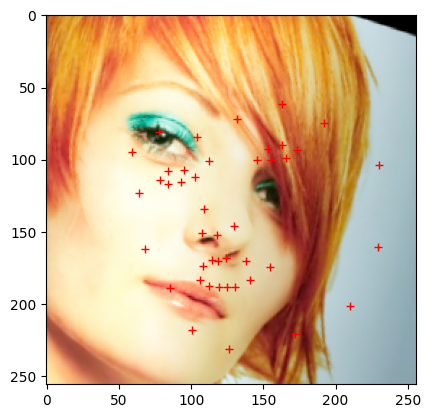

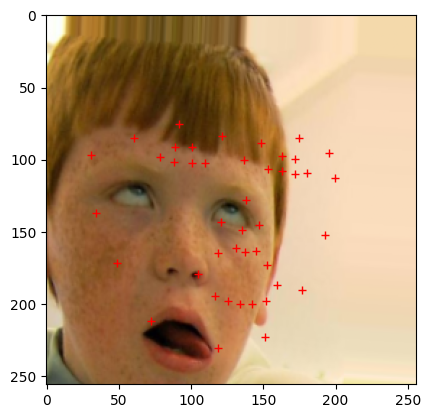

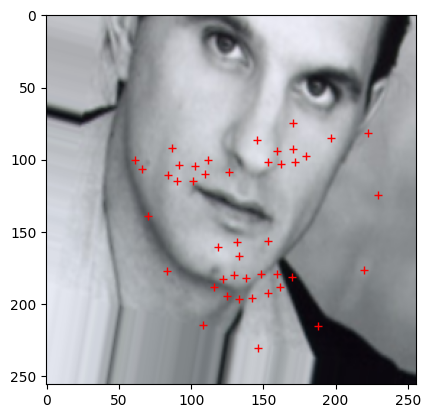

In [ ]:
# Plot augmented images
for i in range(3):
    visualise_pts(augmented_images[i], augmented_pts[i])

In [ ]:
# Defining our CNN model class here
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(88))  # 44 points with 2 values (x, y) each
    return model

In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the CNN model
batch_size = 32
epochs = 30

train_generator = datagen.flow(images, pts.reshape(-1, 88), batch_size=batch_size)
model.fit(train_generator, epochs=epochs, steps_per_epoch=len(images) // batch_size)

Epoch 1/10
87/87 [==============================] - 444s 5s/step - loss: 1834.0137
Epoch 2/10
87/87 [==============================] - 439s 5s/step - loss: 171.3680
Epoch 3/10
87/87 [==============================] - 450s 5s/step - loss: 141.0270
Epoch 4/10
87/87 [==============================] - 446s 5s/step - loss: 145.1554
Epoch 5/10
87/87 [==============================] - 434s 5s/step - loss: 140.7177
Epoch 6/10
87/87 [==============================] - 451s 5s/step - loss: 138.1863
Epoch 7/10
87/87 [==============================] - 444s 5s/step - loss: 153.5719
Epoch 8/10
87/87 [==============================] - 444s 5s/step - loss: 136.3734
Epoch 9/10
87/87 [==============================] - 441s 5s/step - loss: 136.3476
Epoch 10/10
87/87 [==============================] - 440s 5s/step - loss: 139.9037


In [ ]:
# Predicting the landmarks on the test set
predicted_pts = model.predict(test_images).reshape(-1, 44, 2)

18/18 [==============================] - 27s 2s/step


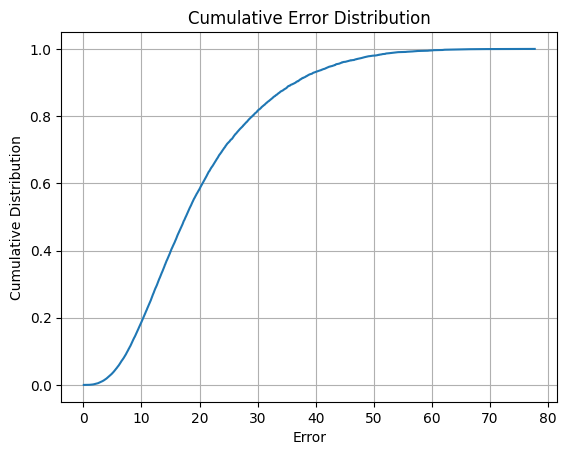

In [ ]:
# Calculating the errors for each image
all_errors = []
for i in range(len(test_images)):
    all_errors.extend(euclid_dist(predicted_pts[i], pts[i]))

# Calculating the cumulative error distribution
sorted_errors = np.sort(all_errors)
cumulative_errors = np.cumsum(sorted_errors) / np.sum(sorted_errors)

# Plot cumulative error distribution
plt.figure()
plt.plot(sorted_errors, cumulative_errors)
plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.show()


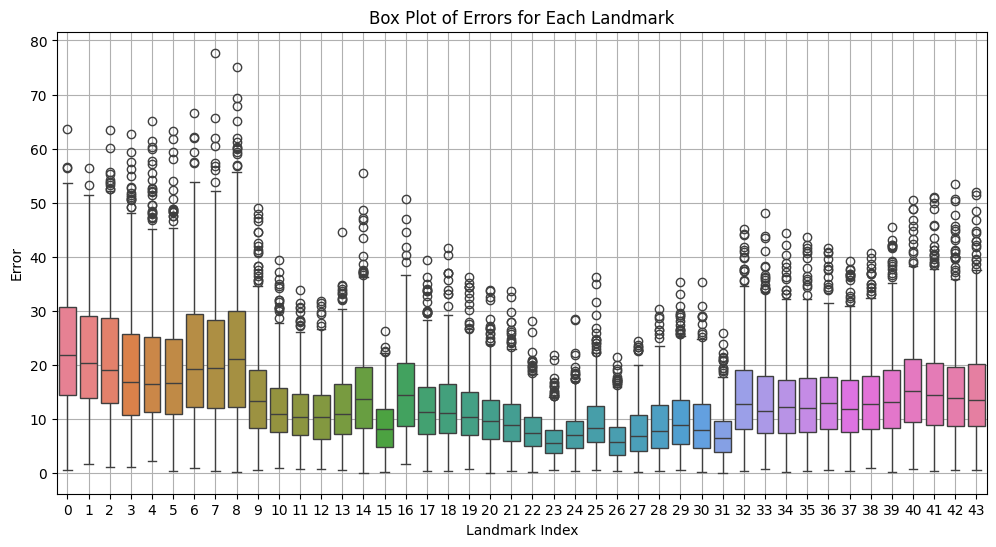

In [ ]:
import seaborn as sns

# Preparing our data for box plot
error_per_landmark = [[] for _ in range(44)]
for i in range(len(test_images)):
    errors = euclid_dist(predicted_pts[i], pts[i])
    for j in range(44):
        error_per_landmark[j].append(errors[j])

# Plot box plot of errors for each landmark
plt.figure(figsize=(12, 6))
sns.boxplot(data=error_per_landmark)
plt.xlabel('Landmark Index')
plt.ylabel('Error')
plt.title('Box Plot of Errors for Each Landmark')
plt.grid(True)
plt.show()


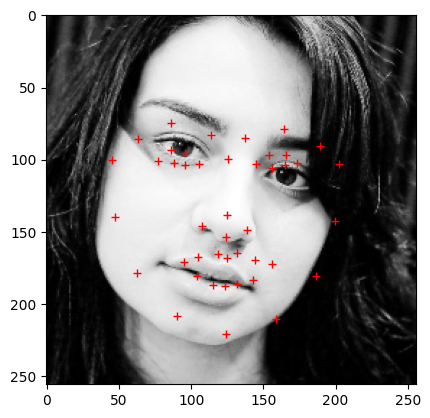

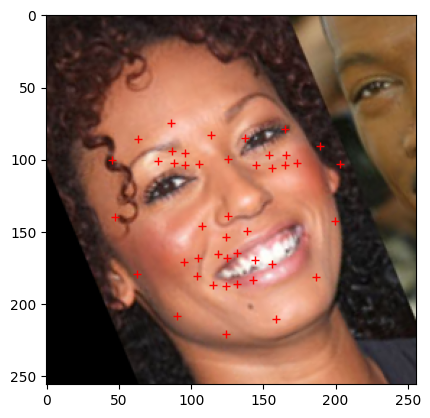

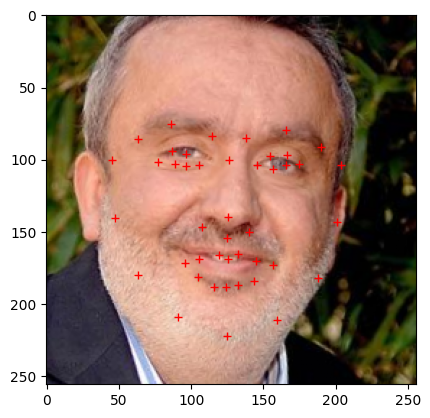

In [ ]:
# Selecting some failure cases based on a threshold
error_threshold = np.percentile(all_errors, 90)  # For example, top 10% errors
failure_indices = [i for i in range(len(test_images)) if max(euclid_dist(predicted_pts[i], pts[i])) > error_threshold]

# Plot failure cases (limit to a few examples)
for idx in failure_indices[:3]:
    visualise_pts(test_images[idx], predicted_pts[idx])


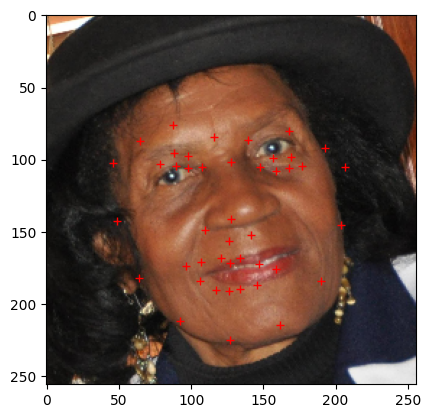

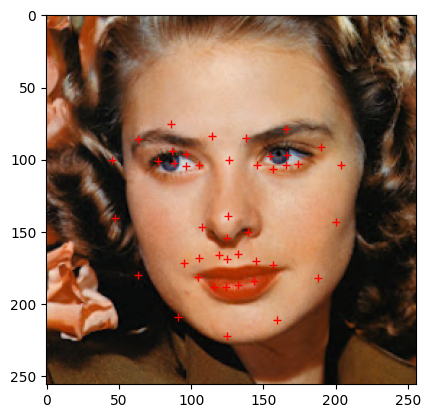

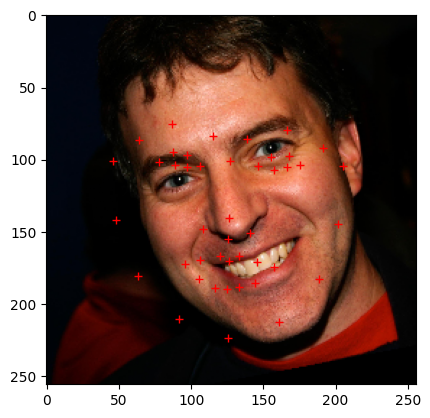

In [ ]:
# Plot predictions on test images
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    visualise_pts(test_images[idx], predicted_pts[idx])

In [ ]:
save_as_csv(predicted_pts)

print("Predictions saved to results.csv")

Predictions saved to results.csv


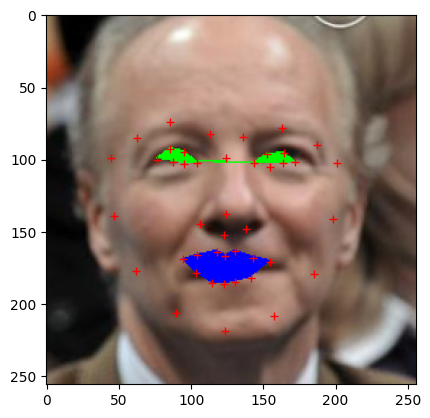

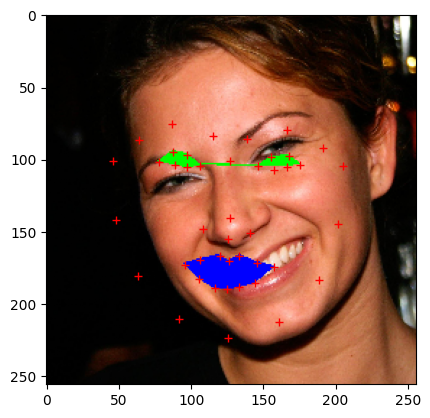

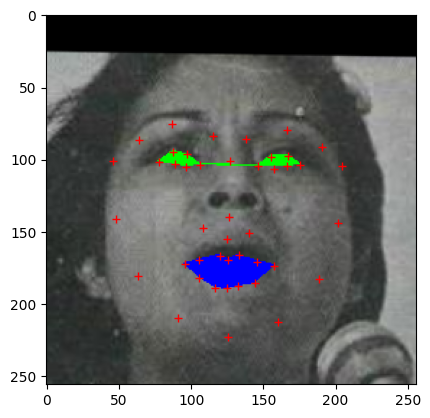

In [ ]:
import cv2

# Function to modify the color of the lips and eyes
def modify_color(img, pts, lip_color=(0, 0, 255), eye_color=(0, 255, 0)):
    img_copy = img.copy()

    # Define lip and eye regions using the landmark indices
    lips_indices = [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]  # Approximate range for lips
    right_eye_indices = [25, 26, 27, 28, 29, 30]  # Approximate range for right eye
    left_eye_indices = [20, 21, 22, 23, 24]  # Approximate range for left eye

    lips_pts = pts[lips_indices].astype(np.int32)
    right_eye_pts = pts[right_eye_indices].astype(np.int32)
    left_eye_pts = pts[left_eye_indices].astype(np.int32)

    # Fill lip region with color
    cv2.fillPoly(img_copy, [lips_pts], lip_color)

    # Fill eye regions with color
    cv2.fillPoly(img_copy, [right_eye_pts], eye_color)
    cv2.fillPoly(img_copy, [left_eye_pts], eye_color)

    return img_copy

# Apply color modification to some test images and plot the results
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    modified_img = modify_color(test_images[idx], predicted_pts[idx])
    visualise_pts(modified_img, predicted_pts[idx])